# LR Analysis

This notebook analyze the LR properties of a system starting from the coupling matrix, transition quantities and the energies of the virtual orbitals

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from futile import Yaml
from futile.Utils import write
import matplotlib.pyplot as plt
import numpy as np
import LRTDDFT as LR
HaeV=27.21138386

Autosave disabled


In [2]:
def build_syst_dict(systPath,norb):
    syst = {}
    outp = systPath+'linear-response/log'
    %cd $outp
    logs = !ls log-Rmult_*
    for l in logs:
        data = lf.Logfile(l)
        rmult = data.log['dft']['rmult'][0]
        nvirt = len(data.evals[0][0]) - norb
        syst[rmult] = {'nvirt':nvirt}
    %cd ../../../../
    return syst
    
def get_tddft_quantities(syst,sysPath):
    from futile.Utils import write
    outp = sysPath+'linear-response/log'
    %cd $outp
    for rVal in syst:
        dpath = 'data-'+'Rmult_'+str(rVal)+'/transition_quantities.txt'
        trans = np.loadtxt(dpath)
        syst[rVal]['T']=trans
        cpath = 'data-'+'Rmult_'+str(rVal)+'/coupling_matrix.txt'
        Cmat = np.loadtxt(cpath)
        syst[rVal]['C']=Cmat
        write('Casida Matrix is symmetric',np.allclose(Cmat,Cmat.T,atol=1.e-12))
        syst[rVal]['logfile'] = lf.Logfile('log-Rmult_'+str(rVal)+'_numVirt_'+str(syst[rVal]['nvirt'])+'.yaml')
    %cd ../../../../

## Analysis of $CO$

In [3]:
norbCO = 5
pathCO = 'CO/free-bc/'
CO = build_syst_dict(pathCO, norbCO)
nalphaCO = [16,64,160,224]
CO

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


{7.0: {'nvirt': 280}, 9.0: {'nvirt': 280}, 10.0: {'nvirt': 280}}

In [4]:
reload(LR)
get_tddft_quantities(CO,pathCO)
LR.diagonalize_CM(norbCO,CO,nalphaCO)
LR.collect_LR(CO)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/CO/free-bc/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY
Solve for rVal =  9.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 224
Eigensystem solved for 280
Solve for rVal =  10.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 224
Eigensystem solved for 280
Solve for rVal =  7.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 224
Eigensystem solved for 280


In [5]:
CO[7.0]['eigenproblems'][16].keys()

['eigenvectors',
 'alpha_xyz',
 'oscillator_strengths',
 'Cmat',
 'eigenvalues',
 'transitions',
 'oscillator_strength_avg']

### Statical polarizability

Plot the convergence of the statical polarizability in the various box

In [122]:
CO_alpha_ref = {'alphaX':13.235,'alphaY':13.235,'alphaZ':18.728}

In [141]:
reload(LR)
alpha_CO = LR.collect_Alpha(CO,norbCO)

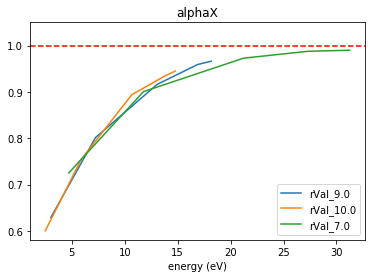

In [142]:
%matplotlib inline
component = 'alphaX'
for rVal in alpha_CO:
    val = np.array(alpha_CO[rVal][component])/CO_alpha_ref[component]
    plt.plot(alpha_CO[rVal]['naEnergy'],val,label='rVal_'+str(rVal))
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title(component)
plt.ylim(ymax=1.05)
plt.show()

### Dynamical polarizability

In [129]:
reload(LR)
CO_spectrum = LR.collect_spectrum(CO)

numpoint =  336  omegaMax (eV) =  45.8177386411
numpoint =  311  omegaMax (eV) =  42.4313836822
numpoint =  434  omegaMax (eV) =  59.1058563081


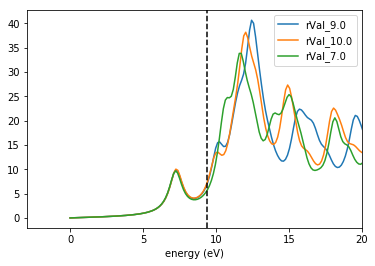

In [130]:
%matplotlib inline
for rVal in CO_spectrum:
    plt.plot(CO_spectrum[rVal]['omega'],CO_spectrum[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
#plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(CO[7.0]['logfile'],norbCO,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

### Excitations

First of all we choose a value of rmult and we plot a given number of excitations according to their threshold value 
and energy

In [131]:
reload(LR)
rVal = 7.0
syst = CO[rVal]
numExc = 1000
nvirt = syst['nvirt']
dict_casida = syst['eigenproblems'][nvirt]
pEng = LR.get_p_energy(syst['logfile'],norbCO)
LR.find_excitation_thr(dict_casida,nvirt,numExc,pEng,5e-2)

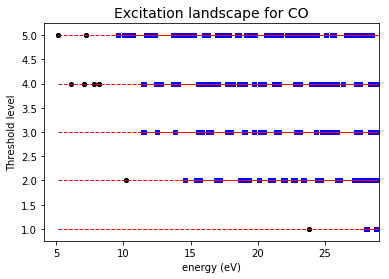

In [132]:
%matplotlib inline
Emin = HaeV*np.sqrt(syst['eigenproblems'][nvirt]['eigenvalues'][0])
Emax = HaeV*np.sqrt(syst['eigenproblems'][nvirt]['eigenvalues'][numExc])

for ind,p in enumerate(pEng):
    plt.plot((Emin,HaeV*abs(p)),(ind+1,ind+1),'--',c='red',linewidth=1)
    plt.plot((HaeV*abs(p),Emax),(ind+1,ind+1),'-',c='red',linewidth=1)
    
for exc in range(numExc):
    eng = HaeV*np.sqrt(syst['eigenproblems'][nvirt]['eigenvalues'][exc])
    thind = syst['eigenproblems'][nvirt]['thresholds'][exc][0]
    th = HaeV*syst['eigenproblems'][nvirt]['thresholds'][exc][1]
    if eng < th : 
        plt.scatter(eng,thind,s=16,marker='o',c='black')
    else :
        plt.scatter(eng,thind,s=14,marker='s',c='blue')
plt.title('Excitation landscape for CO',size=14) 
plt.xlabel('energy (eV)')
plt.ylabel('Threshold level')
plt.xlim(xmin=Emin-1,xmax=Emax)
plt.show()

It is not clear if the multi-threshold scenario is realized in this case. Some excitations below threshold above |eps_h|
seems to be present but the result depend from the choice of the box and of the tolerance. It is better to look for the stability by comparing the excitations dos in different boxes

In [ ]:
############################################################################

In [ ]:
def regroup_excitations(e2,ths,evals):
    channels=[ [] for e in evals]
    for e,th in zip(e2,ths):
        ind=np.argmin(np.abs(evals+th))
        channels[ind].append(np.sqrt(e))
    return channels
from BigDFT import DoS as D
def get_channels(bb):
    tt=bb['eigenproblems'][bb['nvirt']]
    ev=bb['logfilex'].evals[0][0][0:norb].tolist()
    chs=regroup_excitations(tt['eigenvalues'],tt['thresholds'],np.array(ev))
    chs.reverse()
    return [np.array(ch) for ch in chs]

In [ ]:

chs7=get_channels(box[7.0])
chs9=get_channels(box[9.0])
evals=box[9.0]['logfilex'].evals[0][0][0:norb].tolist()

## Analysis of $C_6H_6$

In [98]:
norbC6H6 = 15
pathC6H6 = 'C6H6/free-bc/'
C6H6 = build_syst_dict(pathC6H6, norbC6H6)
nalphaC6H6 = [16,64,160]
C6H6

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY


{7.0: {'nvirt': 220}, 9.0: {'nvirt': 220}, 10.0: {'nvirt': 220}}

In [99]:
reload(LR)
get_tddft_quantities(C6H6,pathC6H6)
LR.diagonalize_CM(norbC6H6,C6H6,nalphaC6H6)
LR.collect_LR(C6H6)

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/C6H6/free-bc/linear-response/log
Casida Matrix is symmetric True
Casida Matrix is symmetric True
Casida Matrix is symmetric True
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY
Solve for rVal =  9.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 220
Solve for rVal =  10.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 220
Solve for rVal =  7.0
Eigensystem solved for 16
Eigensystem solved for 64
Eigensystem solved for 160
Eigensystem solved for 220


In [100]:
C6H6[7.0]['eigenproblems'][16].keys()

['eigenvectors',
 'alpha_xyz',
 'oscillator_strengths',
 'Cmat',
 'eigenvalues',
 'transitions',
 'oscillator_strength_avg']

### Statical polarizability

Plot the convergence of the statical polarizability in the various box

In [133]:
C6H6_alpha_ref = {'alphaX':83.856,'alphaY':83.856,'alphaZ':45.62}

In [143]:
reload(LR)
alpha_C6H6 = LR.collect_Alpha(C6H6,norbC6H6)

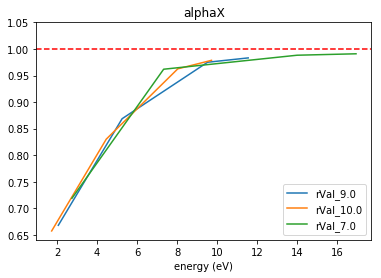

In [144]:
%matplotlib inline
component = 'alphaX'
for rVal in alpha_C6H6:
    val = np.array(alpha_C6H6[rVal][component])/C6H6_alpha_ref[component]
    plt.plot(alpha_C6H6[rVal]['naEnergy'],val,label='rVal_'+str(rVal))
plt.legend(loc='best')
plt.xlabel('energy (eV)')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.title(component)
plt.ylim(ymax=1.05)
plt.show()

### Dynamical polarizability

In [136]:
reload(LR)
C6H6_spectrum = LR.collect_spectrum(C6H6)

numpoint =  240  omegaMax (eV) =  32.7395929853
numpoint =  228  omegaMax (eV) =  31.0826343534
numpoint =  280  omegaMax (eV) =  38.1269227268


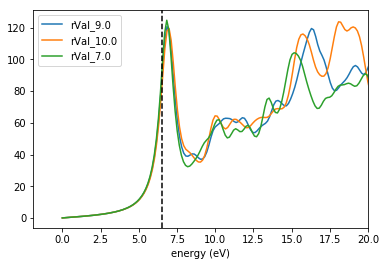

In [138]:
%matplotlib inline
for rVal in C6H6_spectrum:
    plt.plot(C6H6_spectrum[rVal]['omega'],C6H6_spectrum[rVal]['imagPart'],label='rVal_'+str(rVal))
plt.xlim(xmax=20)
plt.legend(loc='best')
plt.xlabel('energy (eV)')
#plt.title('Absorption spectrum')
eps_h = abs(HaeV*LR.get_alpha_energy(C6H6[7.0]['logfile'],norbC6H6,0))
plt.axvline(x=eps_h, color='black', linestyle='--')
plt.show()

### Excitations

First of all we choose a value of rmult and we plot a given number of excitations according to their threshold value 
and energy

In [139]:
reload(LR)
rVal = 7.0
syst = C6H6[rVal]
numExc = 1000
nvirt = syst['nvirt']
dict_casida = syst['eigenproblems'][nvirt]
pEng = LR.get_p_energy(syst['logfile'],norbC6H6)
LR.find_excitation_thr(dict_casida,nvirt,numExc,pEng,5e-2)

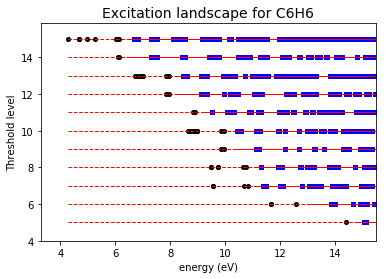

In [145]:
%matplotlib inline
Emin = HaeV*np.sqrt(syst['eigenproblems'][nvirt]['eigenvalues'][0])
Emax = HaeV*np.sqrt(syst['eigenproblems'][nvirt]['eigenvalues'][numExc])

for ind,p in enumerate(pEng):
    plt.plot((Emin,HaeV*abs(p)),(ind+1,ind+1),'--',c='red',linewidth=1)
    plt.plot((HaeV*abs(p),Emax),(ind+1,ind+1),'-',c='red',linewidth=1)
    
for exc in range(numExc):
    eng = HaeV*np.sqrt(syst['eigenproblems'][nvirt]['eigenvalues'][exc])
    thind = syst['eigenproblems'][nvirt]['thresholds'][exc][0]
    th = HaeV*syst['eigenproblems'][nvirt]['thresholds'][exc][1]
    if eng < th : 
        plt.scatter(eng,thind,s=16,marker='o',c='black')
    else :
        plt.scatter(eng,thind,s=14,marker='s',c='blue')
plt.title('Excitation landscape for C6H6',size=14) 
plt.xlabel('energy (eV)')
plt.ylabel('Threshold level')
plt.ylim(ymin=4)
plt.xlim(xmin=Emin-1,xmax=Emax)
plt.show()

In this case the multi-threshold scenario is quite evident. This fact is responsible of the stability of the spectrum above |eps_h|